In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

Sample from Student t distribution using SMC.

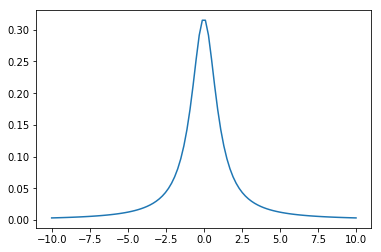

In [12]:
x = np.linspace(-10,10,100)
y = stats.t.pdf(x,1)
plt.plot(x,y)
plt.show()

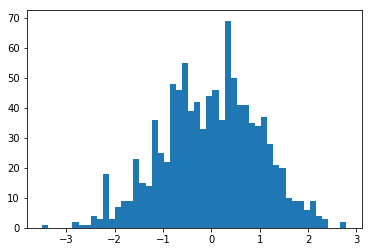

In [171]:
plt.hist(iterateSecondSMCStep(100,10,initialSMCStep(10,1)[0],1000),50)
plt.show()

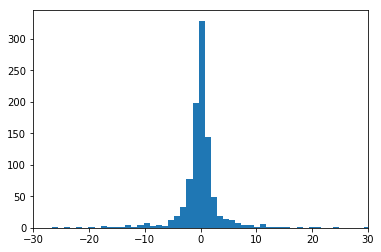

In [88]:
lTest = np.random.standard_t(1,1000)
plt.hist(lTest,1000)
plt.xlim([-30,30])
plt.show()

In [74]:
def q(aCurrent,aPrevious,aSigma):
    return stats.norm.pdf(aCurrent,loc=aPrevious,scale=aSigma)
def gamma(aCurrent,df):
    return stats.t.pdf(aCurrent,df)
def weight(aCurrent,aPrevious,aSigma,df):
    return gamma(aCurrent,df) / (gamma(aPrevious,df) * q(aCurrent,aPrevious,aSigma))
def qSample(aPrevious,aSigma):
    return np.random.normal(loc=aPrevious,scale=aSigma,size=1)[0]
def qSampleAll(lPrevious,aSigma):
    return map(lambda x: qSample(x,aSigma), lPrevious)
def weightsAll(lCurrent,lPrevious,aSigma,df):
    lWeights = map(lambda (x, y): weight(x, y, aSigma, df), zip(lCurrent,lPrevious))
    return lWeights / np.sum(lWeights)
def resample(lWeights,lSamples):
    numSamples = len(lWeights)
    lSelected = np.random.multinomial(numSamples,lWeights)
    lNewSample = np.zeros(0)
    for i in range(0,numSamples):
        if lSelected[i] > 0:
            lNewSample = np.concatenate((lNewSample,np.repeat(lSamples[i],lSelected[i])))
    return lNewSample
def step(lCurrent,aSigma,df):
    lNew = qSampleAll(lCurrent,aSigma)
    lWeights = weightsAll(lNew,lCurrent,aSigma,df)
    lResampled = resample(lWeights,lNew)
    return lResampled
def smc(numIterates,numSamples,aSigma,df):
    mSamples = np.zeros((numSamples,numIterates))
    mSamples[:,0] = step(np.repeat(0,numSamples),aSigma,df)
    for i in range(1,numIterates):
        mSamples[:,i] = step(mSamples[:,i-1],aSigma,df)
    return mSamples.flatten()

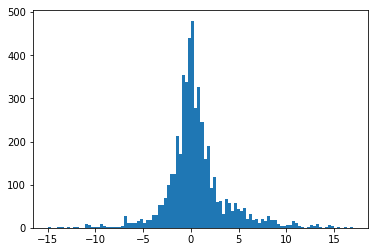

In [83]:
lTest = smc(100,50,2,1)
plt.hist(lTest,100)
plt.show()

# Particle MCMC

In [110]:
def accept(aProposed,aCurrent,df):
    aProposedPDF = stats.t.pdf(aProposed,df)
    aCurrentPDF = stats.t.pdf(aCurrent,df)
    aRand = np.random.uniform()
    if (aProposedPDF / aCurrentPDF) > aRand:
        return aProposed
    else:
        return aCurrent
def stepAndAccept(aCurrent,aSigma,df):
    aProposed = qSample(aCurrent,aSigma)
    return accept(aProposed,aCurrent,df)
def metropolis(numSteps,aSigma,df):
    lSamples = np.zeros(numSteps)
    lSamples[0] = np.random.normal(0,1,1)[0]
    for i in range(1,numSteps):
        lSamples[i] = stepAndAccept(lSamples[i-1],aSigma,df)
    return lSamples
def sequentialStep(aCurrent,numSamples,aSigma,df):
    lCurrent = np.repeat(aCurrent,numSamples)
    lNew = qSampleAll(lCurrent,aSigma)
    lWeights = weightsAll(lNew,lCurrent,aSigma,df)
    lResampled = resample(lWeights,lNew)
    return lResampled
def particleMCMC(numSteps,numSamples,aSigma,df):
    lMetropolis = metropolis(numSteps,aSigma,df)
    mSamples = map(lambda x: sequentialStep(x,numSamples,aSigma,df), lMetropolis)
    return np.concatenate(mSamples,axis = 0).flatten()

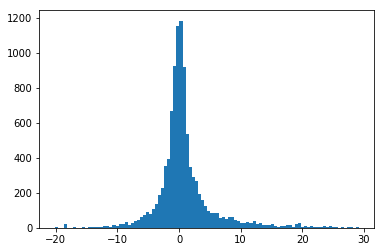

In [119]:
plt.hist(particleMCMC(1000,10,3,1),100)
plt.show()

# SMC done properly

In [152]:
def mixtureTarget(x):
    return 0.5 * (stats.norm.pdf(x,loc=0,scale=1) + stats.norm.pdf(x,loc=8,scale=1))

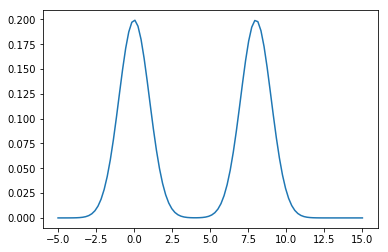

In [153]:
x = np.linspace(-5,15,100)
plt.plot(x,mixtureTarget(x))
plt.show()

In [162]:
def temperedDistribution(x,beta):
    return (mixtureTarget(x) ** beta) * (stats.norm.pdf(x,loc=4,scale=30) ** (1 - beta))

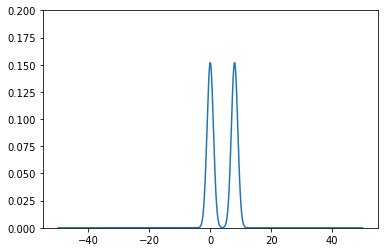

In [167]:
x = np.linspace(-50,50,1000)
plt.plot(x,temperedDistribution(x,0.9))
plt.ylim([0,0.2])
plt.show()

In [403]:
# From Moral et al. (2006) "Sequential Monte Carlo Samplers" algorithm 3.1.1
def initialStep(numParticles):
    lSamples = np.random.normal(loc=4,scale=10,size=numParticles)
    lWeights = map(lambda x: temperedDistribution(x,1) / stats.norm.pdf(x,loc=4,scale=10),lSamples)
    lWeights = lWeights / np.sum(lWeights)
    return lSamples, lWeights
def resample(lWeights,lSamples):
    numSamples = len(lWeights)
    lSelected = np.random.multinomial(numSamples,lWeights)
    lNewSample = np.zeros(0)
    for i in range(0,numSamples):
        if lSelected[i] > 0:
            lNewSample = np.concatenate((lNewSample,np.repeat(lSamples[i],lSelected[i])))
    return lNewSample, np.repeat(1.0/numSamples,numSamples)
def kernelSample(lSamples,beta,aSigma):
    numParticles = len(lSamples)
    lProposed = map(lambda x: np.random.normal(loc=x,scale=aSigma,size=1)[0], lSamples)
    lNewSamples = map(lambda (old,new): old if (temperedDistribution(new,beta) / temperedDistribution(old,beta)) <=
                      np.random.uniform(size=1) else new, zip(lSamples,lProposed))
    return lNewSamples
def wTilde(xOld,xNew,betaOld,betaNew,aSigma):
    numerator = temperedDistribution(xNew,betaNew) * L(xNew,xOld,betaOld,aSigma)
    denominator = temperedDistribution(xOld,betaOld) * K(xOld,xNew,betaNew,aSigma)
    return numerator / denominator
def K(xOld,xNew,beta,aSigma):
    return stats.norm.pdf(xNew,loc=xOld,scale=aSigma) * temperedDistribution(xNew,beta) / temperedDistribution(xOld,beta)
def L(xNew,xOld,beta,aSigma):
    return temperedDistribution(xOld,beta) * K(xOld,xNew,beta,aSigma) / temperedDistribution(xNew,beta)
def newWeight(WOld,xOld,xNew,betaOld,betaNew,aSigma):
    wtilde = wTilde(xOld,xNew,betaOld,betaNew,aSigma)
    return WOld * wtilde
def newWeights(lWOld,lSamplesOld,lSamplesNew,betaOld,betaNew,aSigma):
    lNewW = map(lambda (WOld,xOld,xNew): newWeight(WOld,xOld,xNew,betaOld,betaNew,aSigma),zip(lWOld,lSamplesOld,lSamplesNew))
    return lNewW / np.sum(lNewW)
def steps2And3(lSamplesOld,lWeightsOld,betaOld,betaNew,aSigma):
    lResamples, lWOld = resample(lWeightsOld,lSamplesOld)
    lSamplesNew = kernelSample(lResamples,betaNew,aSigma)
    lNewW = newWeights(lWOld,lSamplesOld,lSamplesNew,betaOld,betaNew,aSigma)
    lResamplesNew, lWeightsNew = resample(lNewW,lSamplesNew)
    return lResamplesNew, lWeightsNew
def iterate(lBetaSchedule,lSamplesFromStep1,lWeightsFromStep1,aSigma):
    numIterates = len(lBetaSchedule)
    numParticles = len(lSamplesFromStep1)
    mSamples = np.zeros((numParticles,numIterates))
    mSamples[:,0] = lSamplesFromStep1
    lWeightsOld = lWeightsFromStep1
    for i in range(0,numIterates-1):
        lNewSamples,lWeightsNew = steps2And3(mSamples[:,i],lWeightsOld,lBetaSchedule[i],lBetaSchedule[i+1],aSigma)
        lWeightsOld = lWeightsNew
        mSamples[:,i+1] = lNewSamples
    return mSamples[:,-1]

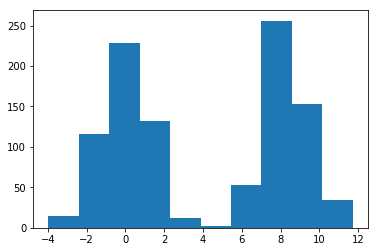

In [407]:
lSamples, lWeights = initialStep(1000)
lBeta = np.linspace(0.0,1.0,10)

plt.hist(iterate(lBeta,lSamples,lWeights,1))
plt.show()

In [256]:
len(lSamples)

10

In [250]:
steps2And3([1,2,3,4],np.repeat(0.25,4),0.5,0.6,1)

(array([-0.14183927,  1.65111927,  3.        ,  4.25945191]),
 array([ 0.25,  0.25,  0.25,  0.25]))